In [1]:
import scipy as sp
from scipy.io import loadmat,savemat
import scipy.sparse.linalg
import numpy as np
import numpy.linalg
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy import misc
import os
from scipy.sparse import csc_matrix, csr_matrix

%matplotlib inline

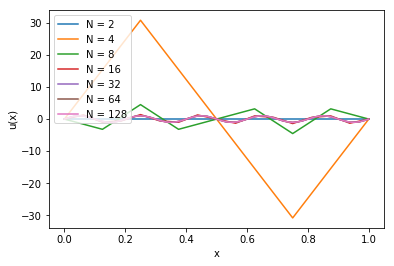

In [8]:
# Solving the 1D Poisson equation u''(x) = f(x) with boundary conditions 
# u(0) = u(1) = 0 and f(x) = -ko^2*pi^2* sin(ko*pi*x)
# here we know the exact solution.

a = 0
b = 1
ko = 10
Ns = np.array([2, 4, 8, 16, 32, 64, 128])

err = np.zeros(len(Ns))
for ii in range(0,len(Ns)):
    
    N = Ns[ii]     
    h = (b-a)/N

    # N+1 grid points
    x = np.linspace(a,b,N+1)

    # tri-diagonal matrix
    A = np.diag(np.ones(N-2), 1) + np.diag(np.ones(N-2), -1) - 2*np.diag(np.ones(N-1))
    A = A/h**2

    # right-hand-side
    f = -np.pi**2 * ko**2 * np.sin(ko*np.pi*x[1:N])

    # solve the system and apply boundary conditions
    u = np.linalg.solve(A,f)
    usol = np.zeros(N+1)
    usol[1:N] = u

    # exact solution
    uexa = np.sin(ko*np.pi*x)

    err[ii] = np.linalg.norm(usol-uexa)/np.linalg.norm(uexa)
    
    plt.plot(x,usol,label = 'N = %d' % N)
    plt.xlabel('x')
    plt.ylabel('u(x)')
    plt.legend(loc = 0)


4.67308911828178

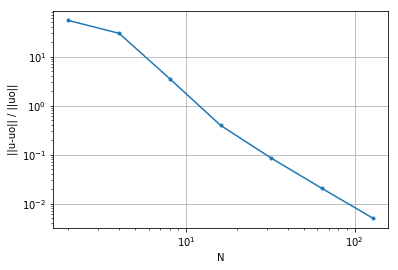

In [9]:
plt.loglog(Ns,err,marker = ".")
plt.xlabel('N')
plt.ylabel('||u-uo|| / ||uo||')
plt.grid()
err
err[3]/err[4]

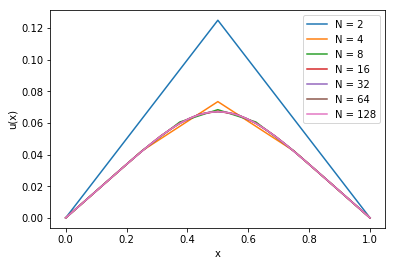

In [11]:
# Solving the 1D Poisson equation u''(x) = f(x) with boundary conditions 
# u(0) = 0 and u(1) = 0 and f(x) = (sin(ko*pi*x))^5
# here we don't know the exact solution. So we solve the problem on the finest 
# grid we can afford on our computer 
# and consider this as the exact solution. We note that we must divide our grid 
# by 2 as we refine in order to be able to compare
# the numerical coarse solution with the numerical finest solution at their 
# exact points.

def poisson1D(N,ko):

    a = 0
    b = 1
    h = (b-a)/N

    # N+1 grid points
    x = np.linspace(a,b,N+1)

    # tri-diagonal matrix
    A = np.diag(np.ones(N-2), 1) + np.diag(np.ones(N-2), -1) - 2*np.diag(np.ones(N-1))
    A = A/h**2

    # right-hand-side
    f = -np.sin(ko*np.pi*x[1:N])**5

    # solve the system and apply boundary conditions
    u = np.linalg.solve(A,f)
    usol = np.zeros(N+1)
    usol[1:N] = u
    return x, usol

# solve at a fine grid
ko = 1
Nexa = 1024
xexa, uexa = poisson1D(Nexa,ko)

Ns = np.array([2, 4, 8, 16, 32, 64, 128])
err = np.zeros(len(Ns))
for ii in range(0,len(Ns)):
    
    N = Ns[ii]     
    x,usol = poisson1D(N,ko)

    # exact solution
    uexa0 = uexa[::int(Nexa/N)]

    err[ii] = np.linalg.norm(usol-uexa0)/np.linalg.norm(uexa0)
    
    plt.plot(x,usol,label = 'N = %d' % N)
    plt.xlabel('x')
    plt.ylabel('u(x)')
    plt.legend(loc = 0)


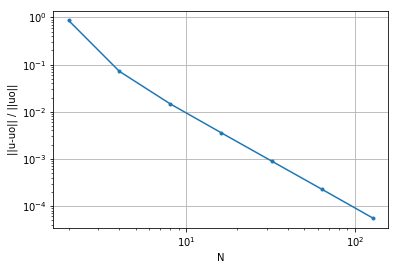

In [12]:
plt.loglog(Ns,err,marker = ".")
plt.xlabel('N')
plt.ylabel('||u-uo|| / ||uo||')
plt.grid()

Here, we will examine a leaky heat-conducting bar to give you practice developing a numerical technique for a physical problem described by a PDE. The following Poisson equation describes the steady-state temperature distribution due to thermal diffusion in a heat-conducting bar:

$$\frac{\partial^2 T(x)}{\partial x^2} = \frac{\kappa_a}{\kappa_m(x)}
\left(T(x) - T_0\right) - \frac{H(x)}{\kappa_m(x)}$$

where $ T(x) $ is the temperature at a point in space $ x $, $ H(x)
$ is the heat generated at $ x $, $ \kappa_m $ is the thermal
conductivity along the metal bar, and $ \kappa_a $ is the thermal
conductivity from the bar to the surrounding air. The temperature $
T_0 $ is the surrounding air temperature. The ratio $
\frac{\kappa_a}{\kappa_m} $ will be small as heat moves much more
easily along the bar than dissipates from the bar into the
surrounding air.

Now suppose one is trying to decide if it is necessary to have heat
sink (a heat sink is usually just a large chunk of metal which
dissipates heat rapidly enough to stay close to room temperature)
connections at both ends of an electronic package.  A heat-sink
connection at only one end would be cheaper, but the heat sink must
prevent the temperature from exceeding a designed maximum.  You can
use simulation to help you make this decision.

We will use our simulator to numerically solve the above Poisson
equation for $ T(x) $, $ x \in [0,1] $, given $ H(x) = 35 (\cos(2\pi
x))^2 $ for $ x \in [0,1]$, $ \kappa_a = 0.005 $, and $ \kappa_m =
0.1 $. In addition, assume the ambient air temperature is $T_0 =
250$, and $T(0) = T(1) = 200 $. The boundary conditions
at $ x=0 $ and $ x=1 $ models heat-sink connections to a cool metal
cabinet at both ends of the package. 


$$\frac{f_{i+1} - 2f_i + f_{i-1}}{h^2} = \frac{k_a}{k_m} (f_i - T_o) - \frac{H_i}{k_m} $$
$$H_i = 35(\cos(2\pi h i))^2, i \in [0, N] $$
$$h = \frac 1 N $$

$$ \begin{cases}
f_{i-1} + (-2 - \frac{k_a}{k_m} h^2) f_i + f_{i+1} = -h^2 \frac{T_o k_a + H_i}{k_m} \\
f_o = f_N = 200
\end{cases}$$
$$ \alpha = (-2 - \frac{k_a}{k_m} h^2) $$
$$ \begin{cases}
f_{i-1} + \alpha f_i + f_{i+1} = R_i \\
f_o = f_N = 200
\end{cases}$$

$$ \begin{cases}
200 + f_1 \alpha + f_2 = R_1 \\
f_1 + f_2 \alpha + f_3 = R_2 \\
\vdots \\
f_{n-3} + f_{n-2} \alpha + f_{n-1} = R_{n-2} \\
f_{n-2} + f_{n-1} \alpha + 200 = R_{n-1} \\
\end{cases}$$

$$\begin{bmatrix} 
\alpha & 1 & 0 & \dots \\ 
1 & \alpha & 1 & 0 & \dots \\  
0 & 1 & \alpha & 1 & 0 & \dots \\ 
\dots \\
0 & 0 & \dots & 0 & 1 & \alpha
\end{bmatrix} \times \left[ \begin{array}{c} f_1 \\ \vdots \\ f_{n-1} \end{array} \right] = \left[ \begin{array}{c} R_1 - 200  \\ R_2 \\ \vdots \\ R_{n-2} \\ R_{n-1} - 200 \end{array} \right] $$

In [13]:
def H(x):
    return 35 * (np.cos(2 * np.pi * x))**2
#k_a = 0.005
#k_m = 0.1
#T_0 = 250
#n = 100
def thermal_conductivity(n = 100, k_a = 0.005, k_m = 0.1, T_0 = 250):
    h = 1.0 / (n + 1)
    ex = np.ones(n, dtype = float)
    lp_x = sp.sparse.spdiags(np.vstack((ex, -2*ex, ex)), [-1, 0, 1], n, n, 'csr')
    lp_x = lp_x / h**2
    M_x = lp_x - (k_a / k_m)*sp.sparse.eye(n)
    rhs = np.zeros(n, dtype = float)  
    for i in range (n):
        rhs[i] = -k_a / k_m * T_0 - H((i+1) * h) / k_m
    rhs[0] = rhs[0] - 200/h**2
    rhs[n-1] = rhs[n-1] - 200/h**2
    solve = sp.sparse.linalg.spsolve (M_x, rhs)
    solve = np.insert (solve, 0, 200)
    solve = np.append (solve, 200)
    plt.plot (np.linspace(0, 1, n +2), solve, label = 'N = %d' % n)
    plt.xlabel ('x')
    plt.ylabel ('T(x)')

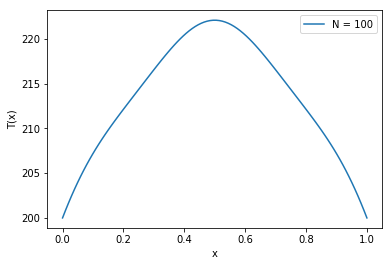

In [15]:
thermal_conductivity(100)
plt.legend(loc = 0)

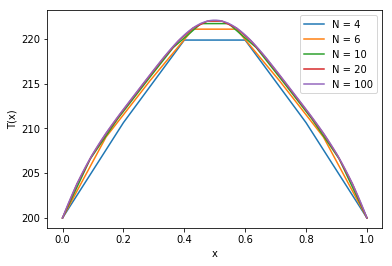

In [8]:
for n in [ 4, 6, 10, 20, 100]:
    thermal_conductivity(n = n)
    plt.legend(loc = 0)
    